<a href="https://colab.research.google.com/github/BedinEduardo/Colab_Repositories/blob/master/06_Exercises_PyTorch_ZTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exercices

## 1. Make predictions on the entire test dataset and plot confusion matrix for the resultsof our model compared to the truth labels.


In [ ]:
# 1.
# Import the library going_to_modular by Daniel Bourke to use data_setup and engine function to our code
#This code brings the modular functions to run, train, and test steps without the need to type everything again
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 4393 (delta 1456), reused 1401 (delta 1401), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 27.78 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


## 1.1 Get the data

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

#Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"  #images from subsets of classess from the Food101 datasets

#if the image doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download")
else:
  print(f"Did not find image path, download it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip") #always get the raw file.
    print("Download pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(image_path)

  #Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find image path, download it...
Download pizza, steak, sushi data...
Unzipping pizza, steak, and sushi data...


In [ ]:
# Setting the directory path

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 1.2 Build Datasets and Dataloaders

In [ ]:
from torchvision import transforms

#normalize
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],   #normalize the data
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize])  #make sure images have the same distribution as ImageNet (where our pretrained models have been trained)


In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7872d278b890>,
 ['pizza', 'steak', 'sushi'])

## 1.3 Building a transform for `torchvision.models` (auto building)

In [ ]:
#get weights of a pretrained model
weigths = torchvision.models.EfficientNet_B0_Weights.DEFAULT   #best avaliable weights

weigths

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
#Get the transforms used to build our pretrained weights
auto_transforms = weigths.transforms()

auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#Build DataLoaders using automatic transforms
train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=auto_transforms,
                                                                           batch_size=32)

train_dataloader, test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7872d279f210>,
 ['pizza', 'steak', 'sushi'])

## 1.4 getting the pretrained model

In [ ]:
weigths = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weigths)

model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 94.7MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 1.5 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
from torchinfo import summary


summary(model=model,
        input_size=(1,3,224,224),  #example of [batch_size, color_channel, height, width]
        col_names=["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## 1.6 Freezing the base model and changing the ouputlayer to suit our needs

In [ ]:
model.features


Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
#device agnostive code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
#Update the classifier head of our model to suit
from torch import nn
torch.manual_seed(47)
torch.cuda.manual_seed(47)

model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                 nn.Linear(in_features=1280,
                                           out_features=len(class_names)) #feature vector comming in
                                 ).to(device)

print(model.classifier)


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [ ]:
summary(model=model,
        input_size=(1,3,224,224),  #example of [batch_size, color_channel, height, width]
        col_names=["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 1.7 Training the mode



In [ ]:
#define the loss and the optmizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
#Importing training function
from going_modular.going_modular import engine

#set the manual seed
torch.manual_seed(47)
torch.cuda.manual_seed(47)

#start the timer
from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_timer = timer()
total_times = end_timer - start_time
print(f"[INFO] Total training time: {total_times}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0891 | train_acc: 0.4219 | test_loss: 0.8204 | test_acc: 0.8551
Epoch: 2 | train_loss: 0.8649 | train_acc: 0.6719 | test_loss: 0.7745 | test_acc: 0.7945
Epoch: 3 | train_loss: 0.8018 | train_acc: 0.6992 | test_loss: 0.7002 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7026 | train_acc: 0.7734 | test_loss: 0.6544 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.5807 | train_acc: 0.9102 | test_loss: 0.5648 | test_acc: 0.8561
[INFO] Total training time: 177.792982899


## 1.8 Plot curves

[INFO] Couldn't find helper_functions.py, downloading...


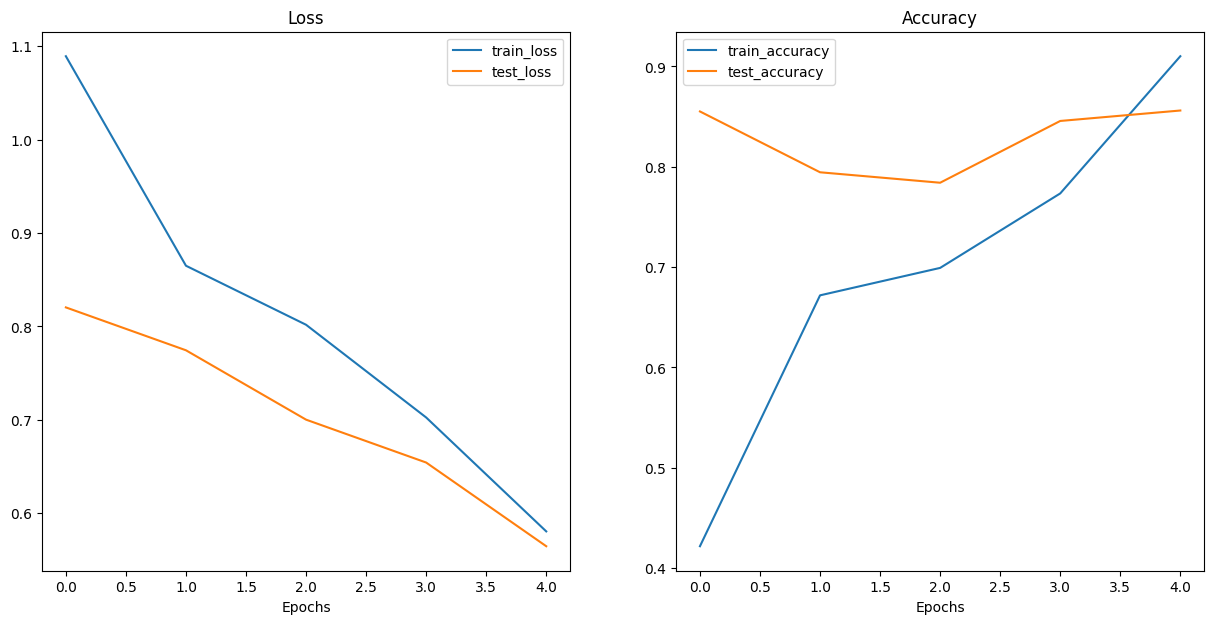

In [ ]:
try:
  from helper_functions import plot_loss_curves

except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")

  with open("helper_functions.py","wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    f.write(request.content)
    from helper_functions import plot_loss_curves

#plot loss curves of our model
plot_loss_curves(results)

## 1.9 Make predictions

In [ ]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

#1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: str,
                        image_size: Tuple[int, int] = (224, 224),  #this value can be changed according network configuration
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)
  # 3. Build a transform if one doesn't exists
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])
    ])

    # Predict the image
    # 4. Make sure the model is in right device
    model.to(device)
    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform the image and add an extra batch dimension
      transformed_image = image_transform(img).unsqueeze(dim=0)  #add a dimension in zero address
      # 7. Make a prediction on the transformed image by passing the model (also ensure it is on the target device)
      target_image_pred = model(transformed_image.to(device))
      # 8. Convert the model's output logits to pred_probs
      target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
      print(target_image_pred_probs)
      # 9. Convert model's pred prob to pred labels
      target_image_pred_label = torch.argmax(target_image_pred_probs, dim =1)
      # 10. Plot image with predicted label and probability
      plt.figure()
      plt.imshow(img)
      plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
      plt.axis(False)


There are 3 in test directory
There are 3 in test directory
There are 3 in test directory
There are 3 in test directory
12
tensor([[0.5146, 0.2351, 0.2503]])
tensor([[0.1224, 0.2764, 0.6012]])
tensor([[0.1905, 0.1750, 0.6345]])
tensor([[0.4368, 0.2043, 0.3589]])
tensor([[0.5768, 0.3392, 0.0840]])
tensor([[0.4932, 0.2570, 0.2498]])
tensor([[0.1789, 0.2200, 0.6010]])
tensor([[0.1001, 0.3445, 0.5555]])
tensor([[0.5248, 0.2966, 0.1786]])
tensor([[0.0789, 0.8284, 0.0927]])
tensor([[0.6780, 0.1576, 0.1644]])
tensor([[0.1964, 0.4912, 0.3123]])


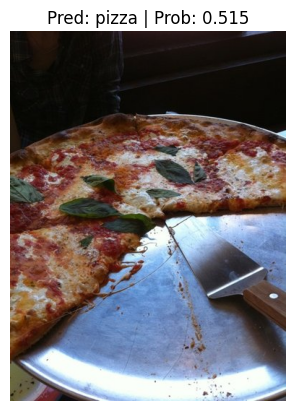

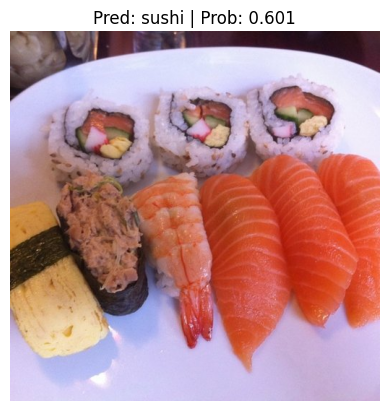

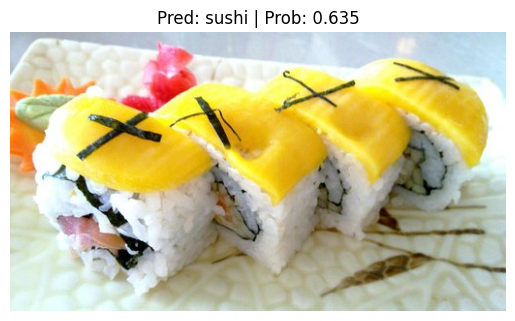

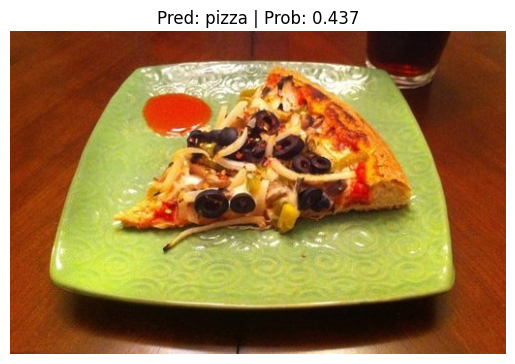

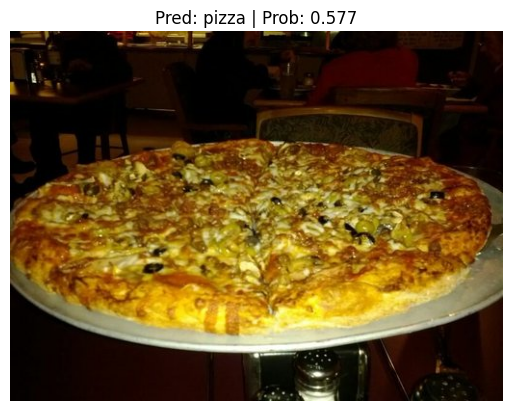

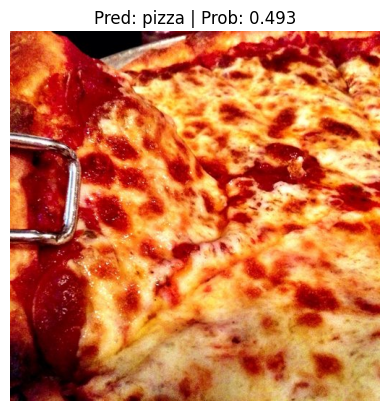

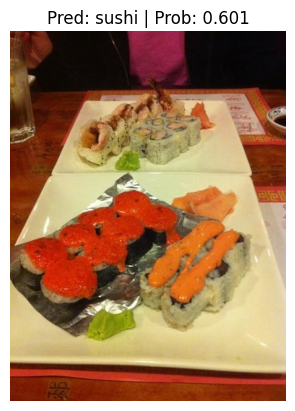

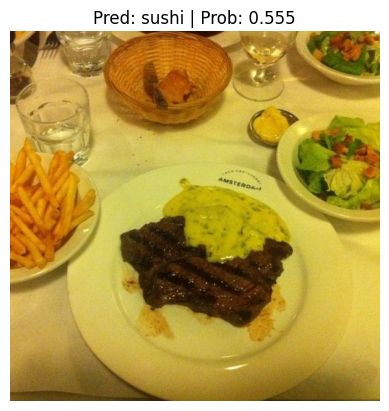

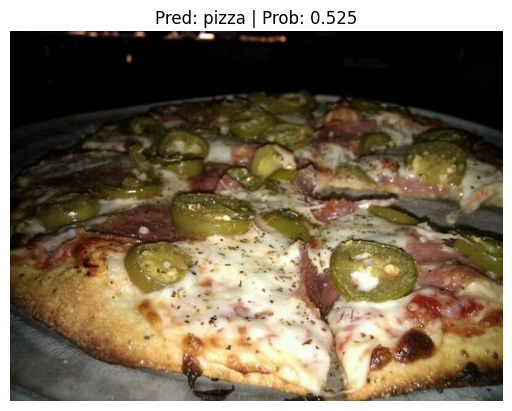

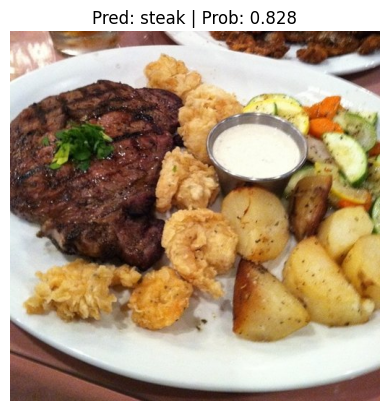

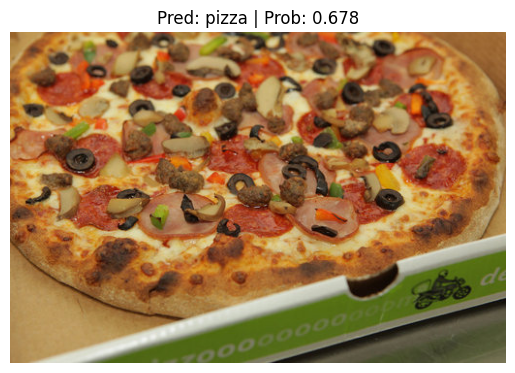

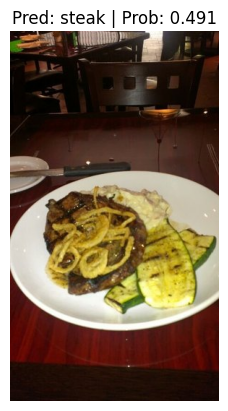

In [ ]:
# Get a list of image paths from test set
import random
import os
count_file = 0
for filenames in os.walk(test_dir):  #find a way to read better this directories
  print(f"There are {len(filenames)} in test directory")
  count_file += len(filenames)
print(count_file)

num_images_to_plot = count_file
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

#make predictions and plot the images
worst_pred_prob = []
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size = (224,224))

